# Convolutional Neural Networks

<a href="https://colab.research.google.com/github/chattopadhyayA/ml_pursue2025/blob/master/content/08_CNN.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## When to use?

Convolutional neural networks are useful, when the data itself have some inherent symmetry. For example in the following figure one can see that there is a clear translational invariance. Question is, if we can exploit this?

```{figure} images/same9.png
---
height: 300px
name:   same9
align:  center
---
"Two same digit from the MNIST dataset"
```
---
- A **convolution** is a mathematical operation that combines two functions $𝑓$ and $ℎ$, producing a third function $𝑔$, written as:

$$
g(t)=(f * h)(t) = \int_{-\infty}^{\infty} f(\tau) \cdot h(t - \tau) \, d\tau'
$$

- In physics, convolution is used to calculate Green's function for linear partial differential equations (diffusion, wave equation) and/or signal filtering.

- For simple $2D$ images, normally we have to use the discrete version of this function

$$
(f * h)[i,j] = \sum_{m}\sum_{n} f[m,n] \cdot h(i - m,j-n)
$$ 

---

#### Simple Example: **1D discrete Convolution**

Let’s say you have a signal 𝑓 and a filter ℎ, the whole process of convolution can be summarised as the following:

$$ f = [3,2,1,0]$$

$$h=[1,0,-1]$$

Now applay convolution:

1.   Flip the filter

$$h_{flipped}=[-1,0,1]$$


2.   Slide the filter across the input and multiply-and-sum at each step:

---

$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{3},2,1,0]$$

$$~~~~~~~~~~[-1,0,\fbox{1}]$$

$ 3*1=3$

---

$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{3},\fbox{2},1,0]$$

$$~~~~~~~~~~~~~~~~~~[-1,\fbox{0}, \fbox{1}]$$


$ 3*0 + 2*1 =2$

---


$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{3},\fbox{2},\fbox{1},0]$$


$$~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{-1},\fbox{0},\fbox{1}]$$


$ 3*(-1) + 2*0 + 1*1 =-2$

---

$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[3,\fbox{2},\fbox{1},\fbox{0}]$$


$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{-1},\fbox{0},\fbox{1}]$$


$ 2*(-1) + 1*0 + 0*1 =-2$

---


$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[3,2,\fbox{1},\fbox{0}]$$


$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{-1},\fbox{0},1]$$


$ 1*(-1) + 0*0  =-1$

---


$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[3,2,1,\fbox{0}]$$


$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[\fbox{-1},0,1]$$


$ 0*(-1)  =0$

---

Resulting convolved signal:

$$f*h= [3,2,-2,-2,-1,0]$$



In [1]:
import numpy as np

a = np.convolve([3,2,1,0],(1,0,-1))

print(a)

[ 3  2 -2 -2 -1  0]



---

In a convolutional layer the convolution operation is performed as shown in the animation. It slides filters over the input image or previous feature maps to extract patterns like edges, textures, and object parts. In a forward-pass, the filter go through the input in the form of scanning according to its specifications (stride, padding etc.), and for every filter stop a convolution (cross-correlation) operation is performed on the corresponding portion of the input to build one output value.

```{figure} images/2D_Convolution_Animation.gif
---
height: 300px
name:   2D_Convolution_Animation
align:  center
---
"Image source: https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif"
```

## Pooling Layer

A pooling layer is used in Convolutional Neural Networks (CNNs) to reduce the spatial dimensions (height and width) of feature maps while preserving the most important information. The pooling layer technique use a kernel that goes though the input and extract one value to the output according to type of the pooling layer. 

![alt text](images/pool.png "Title")

The advantages being

*   Makes the model faster and lighter,
*   Prevents overfitting,
*   Helps the model focus on key features, not exact pixel positions.

The best explanation of CNN, as I have seen is the [3Blue1Brown](https://www.youtube.com/watch?v=KuXjwB4LzSA&ab_channel=3Blue1Brown) video.

![alt text](images/comp_conv.png "Title")





---

## <span style="color:maroon"> CNN Implementation </span>

Here we will use the MNIST database of large number of handwritten digits.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set manual seed for reproducibility
torch.manual_seed(42)

# Loading the MNIST dataset, already included with torchvision dataset

transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)


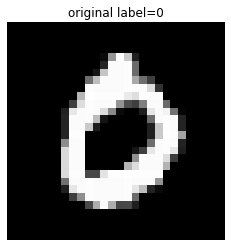

torch.Size([1, 28, 28])


In [7]:
# Show a single image
def show_image(img, title=""):
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

test_image, test_label = test_set[3]
show_image(test_image, title="original label={}".format(test_label))
print(test_image.shape)


In [8]:
# Simple CNN model

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # conv1: Input channels = 1 (grayscale), Output channels = 4, Kernel size = 3x3
        # Input image: 28x28 -> Output: (28 - 3 + 1) = 26x26
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)

        # MaxPool1: 2x2 pooling reduces 26x26 to 13x13
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2: Input channels = 4, Output channels = 8, Kernel size = 3x3
        # Input: 13x13 -> Output: (13 - 3 + 1) = 11x11
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)

        # MaxPool2: 2x2 pooling reduces 11x11 to 5x5
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected (FC) Layer: Input = 8 feature maps * 5 * 5 = 200
        # Output = 10 classes (e.g., MNIST digits)
        self.fc = nn.Linear(in_features=8 * 5 * 5, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # Shape: [batch, 4, 13, 13]
        x = self.pool2(F.relu(self.conv2(x)))  # Shape: [batch, 8, 5, 5]
        x = x.view(-1, 8 * 5 * 5)              # Flatten to [batch, 200]
        x = self.fc(x)                         # Output: [batch, 10]
        return x



In [9]:
# Here goes the training
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training the CNN...")
for epoch in range(10):  # few epochs for demonstration
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.3f}")


Training the CNN...
Epoch 1 - Loss: 420.520
Epoch 2 - Loss: 143.036
Epoch 3 - Loss: 112.597
Epoch 4 - Loss: 96.404
Epoch 5 - Loss: 86.154
Epoch 6 - Loss: 79.574
Epoch 7 - Loss: 73.306
Epoch 8 - Loss: 69.770
Epoch 9 - Loss: 66.393
Epoch 10 - Loss: 62.597


In [10]:
# Get one test image
test_image, test_label = test_set[0]
input_image = test_image.unsqueeze(0)  # add batch dim: [1, 1, 28, 28]

# Run through model
model.eval()
with torch.no_grad():
    x1 = torch.relu(model.conv1(input_image))
    x2 = model.pool1(x1)

    x3 = torch.relu(model.conv2(x2))
    x4 = model.pool2(x3)

    flat = x4.view(-1, 8 * 5 * 5)
    logits = model.fc(flat)
    probs = torch.softmax(logits, dim=1)
    prediction = probs.argmax(dim=1).item()


True Label: 7 | Predicted: 7


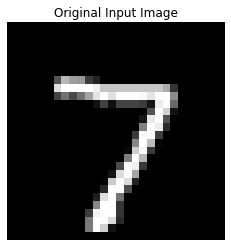

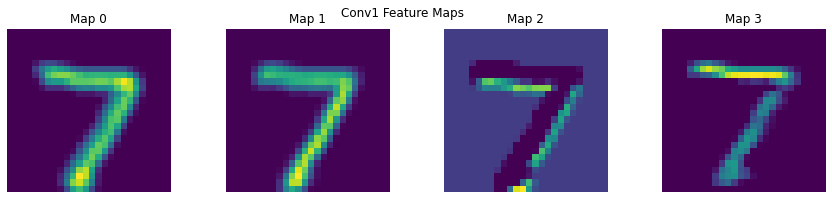

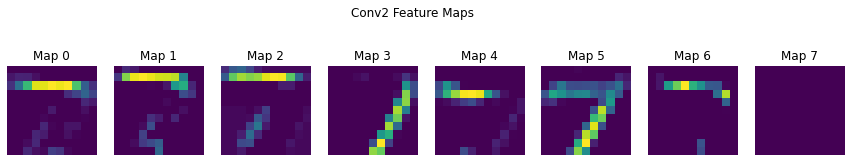

In [11]:
# Showing the original one

print(f"True Label: {test_label} | Predicted: {prediction}")
show_image(test_image, title="Original Input Image")

# Feature map visualisation

def show_feature_maps(tensor, title=""):
    tensor = tensor.squeeze()
    num_maps = tensor.shape[0]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))
    for i in range(num_maps):
        axes[i].imshow(tensor[i], cmap='viridis')
        axes[i].set_title(f"Map {i}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_feature_maps(x1, "Conv1 Feature Maps")
show_feature_maps(x3, "Conv2 Feature Maps")


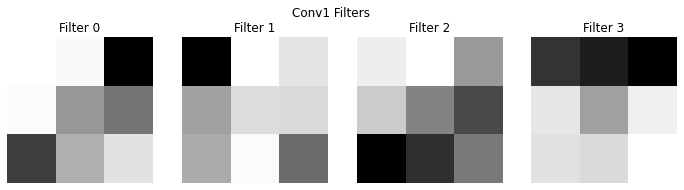

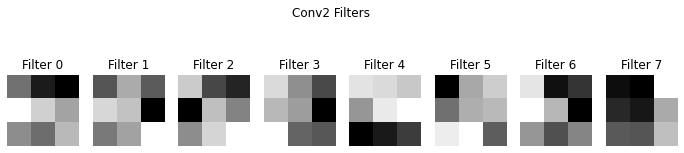

In [12]:

# Visualising the filter itself

def show_conv_filters(conv_layer, title=""):
    weights = conv_layer.weight.data.clone()
    num_filters = weights.shape[0]
    fig, axes = plt.subplots(1, num_filters, figsize=(12, 3))
    for i in range(num_filters):
        axes[i].imshow(weights[i, 0], cmap='gray')
        axes[i].set_title(f"Filter {i}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_conv_filters(model.conv1, "Conv1 Filters")
show_conv_filters(model.conv2, "Conv2 Filters")
